In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2021 - 2022 United Kingdom Research and Innovation
#  Copyright 2021 - 2022 The University of Manchester
#  Copyright 2021 - 2022 The Karlsruhe Institute of Technology
#  Copyright 2021 - 2022 Technical University of Denmark 
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Evelina Ametova (KIT)
#                   Jakob S. Jørgensen (DTU)
#                   Gemma Fardell (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)
#                   Edoardo Pasca (UKRI-STFC)

# Reconstruction intro
## FBP, CGLS, SIRT

**The goal** of this notebook is to get familiar with the CIL `Algorithm` and `Operator` classes through basic Conjugate Gradient Least Squares (CGLS) reconstruction and Simultaneous Image Reconstruction Technique (SIRT).

**Learning objectives**

In the end of this session, participants will be able to:
- formulate CT reconstruction as an optimisation problem and solve it iteratively
- introduce constraints in the optimisation problem
- visualise final and intermediate reconstruction results

In [2]:
# cil imports
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData

from cil.processors import Slicer, AbsorptionTransmissionConverter, TransmissionAbsorptionConverter

from cil.optimisation.functions import IndicatorBox
from cil.optimisation.algorithms import CGLS, SIRT

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP

from cil.plugins import TomoPhantom

from cil.utilities import dataexample
from cil.utilities.display import show2D, show1D, show_geometry

# External imports
import numpy as np
import matplotlib.pyplot as plt
import logging


In [3]:
# Set logging level for CIL processors:
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.INFO)

In [4]:
# set up default colour map for visualisation
cmap = "gray"

In [5]:
# set the backend for FBP and the ProjectionOperator
device = 'gpu'

In this notebook we will use a classical Shepp-Logan phantom generated with the [TomoPhantom toolbox](https://github.com/dkazanc/TomoPhantom).

In [6]:
# number of pixels
n_pixels = 256

# Angles
angles = np.linspace(0, 180, 256, endpoint=False, dtype=np.float32)


# Setup acquisition geometry
# with sufficient number of projections
ag = AcquisitionGeometry.create_Parallel2D()\
                            .set_angles(angles)\
                            .set_panel(n_pixels, pixel_size=1/n_pixels)

# Setup image geometry
ig = ImageGeometry(voxel_num_x=n_pixels, 
                   voxel_num_y=n_pixels, 
                   voxel_size_x=1/n_pixels, 
                   voxel_size_y=1/n_pixels)

# Get phantom
phantom = TomoPhantom.get_ImageData(num_model=1, geometry=ig)

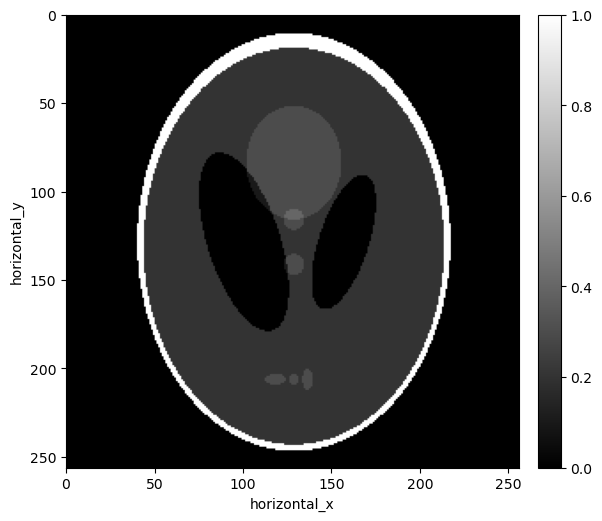

In [7]:
# Visualise data
show2D(phantom, cmap=cmap, num_cols=1, size=(10,10), origin='upper-left')

Next, we create our simulated tomographic data by projecting our noiseless phantom to the acquisition space. Using the image geometry `ig` and acquisition geometry `ag`, we define the `ProjectionOperator`.

In [8]:
# Create projection operator using Astra-Toolbox.
A = ProjectionOperator(ig, ag, device)

# Create an acquisition data (numerically)
sino = A.direct(phantom)


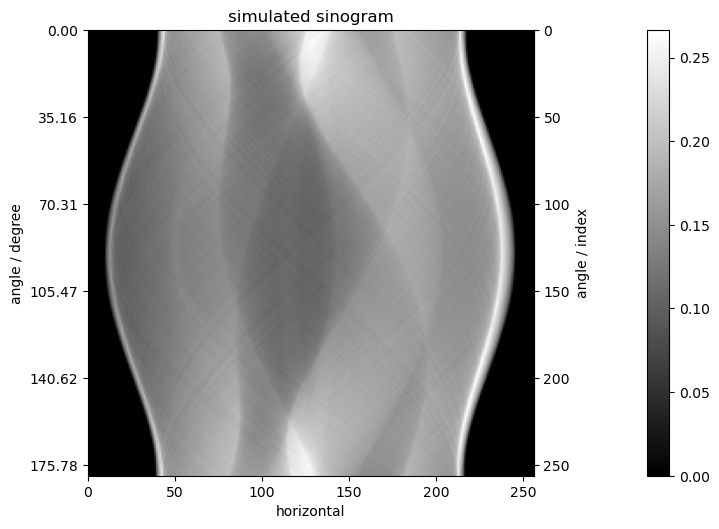

In [9]:
# Visualise data
show2D(sino, 'simulated sinogram', cmap=cmap, size=(10,10), origin='upper-left')

## CT reconstruction
Tomographic reconstruction consists of resolving the three-dimensional photon attenuation map of a scanned object from the collection of projection measurement. There are two major classes of reconstruction algorithms: *analytic* and *iterative*. 

<a id='fbp'></a>
### Analytic reconstruction - a brief recap
The most common analytic reconstruction algorithm is filtered back-projection (FBP). The FBP algorithm is derived from the Fourier Slice theorem which relates line integral measurements to the two dimensional Fourier transform of an object’s slice. Although the Fourier Slice theorem provides a straightforward solution for tomographic reconstruction, its practical implementation is challenging due to the required interpolation from Polar to Cartesian coordinates in the Fourier space. In FBP-type reconstruction methods, projections are ﬁltered independently and then back-projected onto the plane of the tomographic slice. Filtration is used to compensate for non-uniform sampling of the Fourier space (higher frequencies have higher density of sampling points) by linear (Ramp) weighting of the frequency space.

The FBP algorithm is implemented as a `Processor` which is set up with an `AcquisitionGeometry` and an `ImageGeometry`. You then can call your configured FBP processor  on an `AcquisitionData` object. The processor returns the reconstructed `ImageData`.

In [10]:
# reconstruct full data
# configure FBP
fbp = FBP(ig, ag, device)
# run on the AcquisitionData
recon_fbp = fbp(sino)

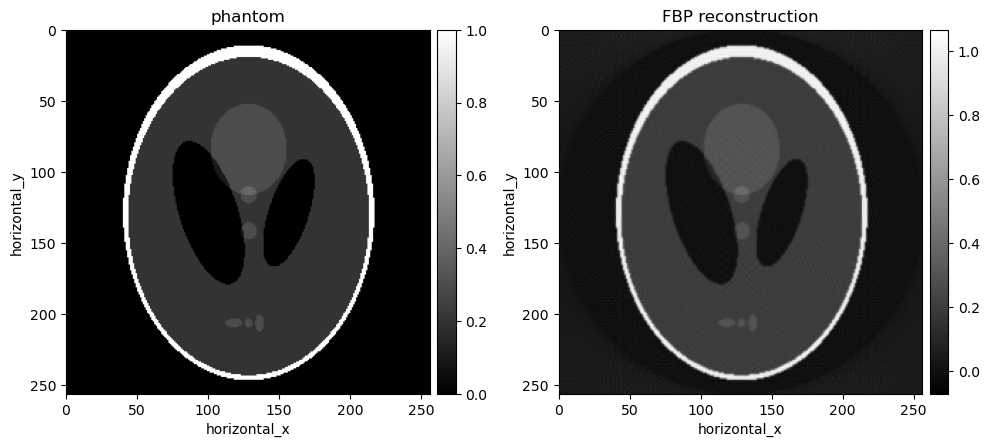

In [11]:
show2D([phantom, recon_fbp], ['phantom', 'FBP reconstruction'], \
       cmap=cmap, num_cols=2, size=(10,10), origin='upper-left')

<a id='cgls'></a>
#### Iterative reconstruction
Iterative methods use an initial estimate of volume voxel values which is then iteratively updated to best reproduce acquired radiographic data. Here we discuss formulation of iterative reconstruction for 2D parallel geometry, extension to other geometries is straightforward. Iterative methods formulate the reconstruction methods as a system of linear equations,

$$Au = b$$

- $u$ is the volume to be reconstructed. $u$ is typically represented as a column vector with $N \cdot N \times 1$ elements, where $N$ is the number of elements in a detector row.
- $b$ is measured data from $M$ measurements (projections), $b$ is a column vector with $N \cdot M \times 1$ elements
- $A$ is the projection operator with $N \cdot M \times N \cdot N$ elements. If $i, i = \{0, 1, \dots N \cdot M - 1 \}$ and $j, j = \{0, 1, \dots, N \cdot N - 1\}$, then $A_{i,j}$ is the length of intersection of the $i$.th ray with the $j$.th voxel.

For any real application, the problem size is too large to be solved by direct inversion methods, i.e.

$$u = A^{-1}b$$

Secondly, the projection matrix $A$ is often under-determined (low number of projections or missing angles), i.e. 

$$M \ll N$$

Therefore we formulate reconstruction as an optimisation problem and use iterative solvers to solve:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}^2_2$$

Since iterative methods involve forward- and back-projection steps, assumptions of data acquisition, data processing, system geometries, and noise characteristic can be incorporated into the reconstruction procedure. However, iterative methods are computationally demanding, you will notice that it takes longer to get reconstruction results with iterative methods.

From mathematical point of view, projection matrix $A$ is an operator which maps from the set $x$ (*domain*) to the set $b$ (*range*):
$$A: u \to b$$
In the framework, we implemented a generic `Operator` class. The two most important methods of the `Operator` are `direct` and `adjoint` methods that describe the result of applying the operator, and its adjoint respectively, onto a compatible `DataContainer` (`AcquisitionData` or `ImageData`) input. The output is another `DataContainer` object or subclass hereof. An important special case of the `Operator` class, is the projection operator $A$ for CT, where `direct` and `adjoint` method correspond to forward- and back-projection respectively. You have already used the `ProjectionOperator` to numerically calculate `AcquisitionData`.

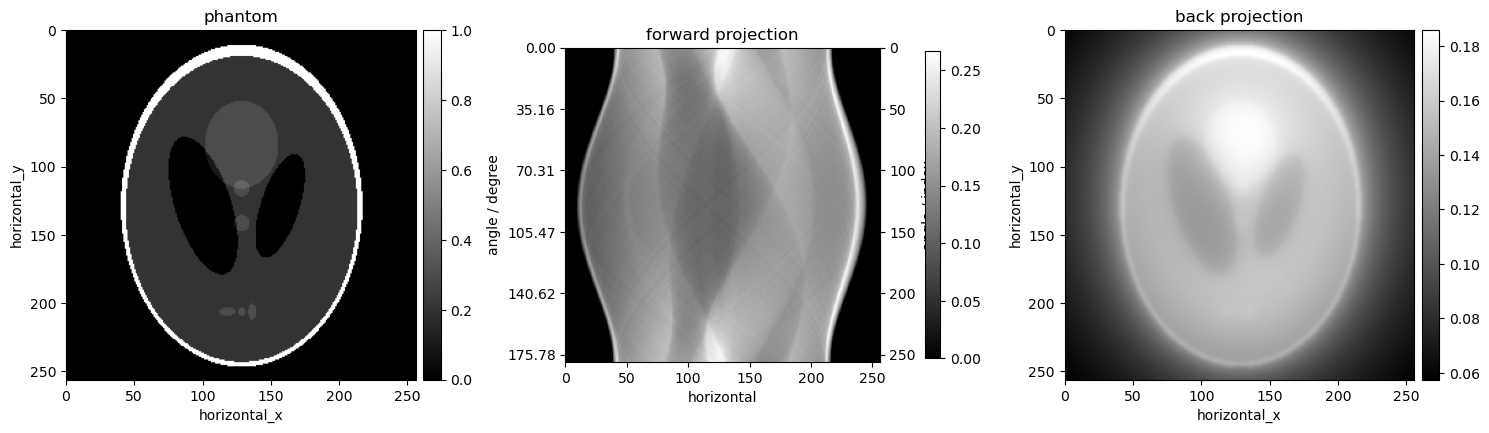

In [12]:
# back_projection
back_projection = A.adjoint(sino)

show2D([phantom, sino, back_projection], ['phantom', 'forward projection', 'back projection'], \
       cmap=cmap, num_cols=3, size=(15,10), origin='upper-left')

In [13]:
print("Range: {} \n".format(A.range_geometry()))
print("Domain: {} \n".format(A.domain_geometry()))

Range: 2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0., 0.]
	Detector position: [0., 0.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [256   1]
	Pixel size: [0.00390625 0.00390625]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 256
	Angles 0-20 in degrees:
[ 0.      ,  0.703125,  1.40625 ,  2.109375,  2.8125  ,  3.515625,
  4.21875 ,  4.921875,  5.625   ,  6.328125,  7.03125 ,  7.734375,
  8.4375  ,  9.140625,  9.84375 , 10.546875, 11.25    , 11.953125,
 12.65625 , 13.359375]
Distances in units: units distance 

Domain: Number of channels: 1
channel_spacing: 1.0
voxel_num : x256,y256
voxel_size : x0.00390625,y0.00390625
center : x0,y0
 



The `Operator` class also has a `norm` method.

In [14]:
print("Operator norm: {}\n".format(A.norm()))

Operator norm: 0.9780738353729248



The Framework provides a number of generic optimisation algorithms implementations. All algorithms share the same interface and behaviour. Algorithms are iterable Python objects which can be run in a for loop, can be stopped and warm restarted.

The Conjugate Gradient Least Squares (CGLS) algorithm is commonly used for solving large systems of linear equations, due to its fast convergence. CGLS takes `operator`, measured data and initial value as an input.

In [15]:
# initial estimate - zero array in this case 
initial = ig.allocate(0)

# setup CGLS
cgls = CGLS(initial=initial, 
            operator=A, 
            data=sino,
            max_iteration = 10,
            update_objective_interval = 1 )

Now we need to run some iterations of the algorithm. This is done via the method `run`. You can specify how many iterations you want to run and the verbosity level, an integer number between 0 and 2.

**Try to run the following cell and then re-run it. What happens?**

In [16]:
# run N interations
cgls.run(5, verbose=True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         10         0.000          1.29816e+03
        1         10         0.027          1.20854e+02
        2         10         0.025          4.29138e+01
        3         10         0.026          2.21475e+01
        4         10         0.026          1.23383e+01
        5         10         0.026          5.68440e+00
-------------------------------------------------------
        5         10         0.026          5.68440e+00
Stop criterion has been reached.



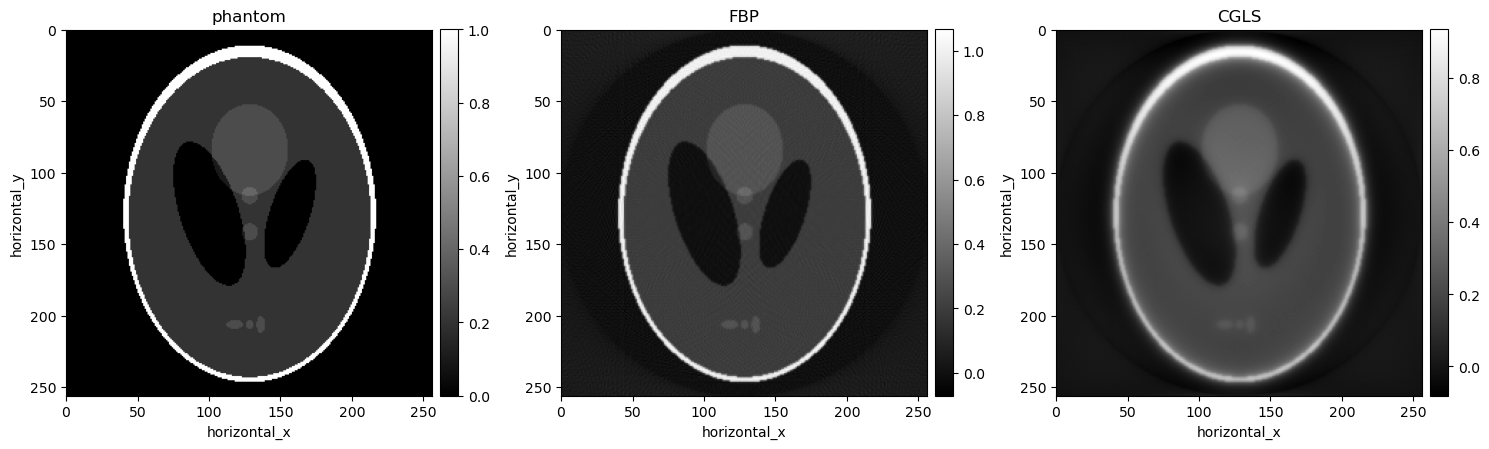

In [17]:
# get and visualise the results
recon_cgls = cgls.solution

show2D([phantom, recon_fbp, recon_cgls], ['phantom', 'FBP', 'CGLS'], \
       cmap=cmap, num_cols=3, size=(15,10), origin='upper-left')

Alternatively, tolerance can be used as a stopping criterion.

In [18]:
# setup CGLS
cgls = CGLS(initial=initial, 
            operator=A, 
            data=sino,
            tolerance=1e-4, # default 1e-6,
            max_iteration = 500,
            update_objective_interval = 10)

Here we want to run until the stopping criterion is met, which for `CGLS` is whichever comes first of the number of iterations limit (`max_iteration`) and reaching the tolerance (`tolerance`).

Omitting the number of iterations, as below, will make the algorithm iterate until it reaches the stopping criterion.

In [19]:
# run N interations
cgls.run(verbose=True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          1.29816e+03
       10        500         0.032          5.95016e-01
       20        500         0.031          6.50076e-02
       30        500         0.032          1.49079e-02
       40        500         0.032          4.28953e-03
       47        500         0.032                     
Tolerance is reached: 0.0001
-------------------------------------------------------
       47        500         0.032                     
Stop criterion has been reached.



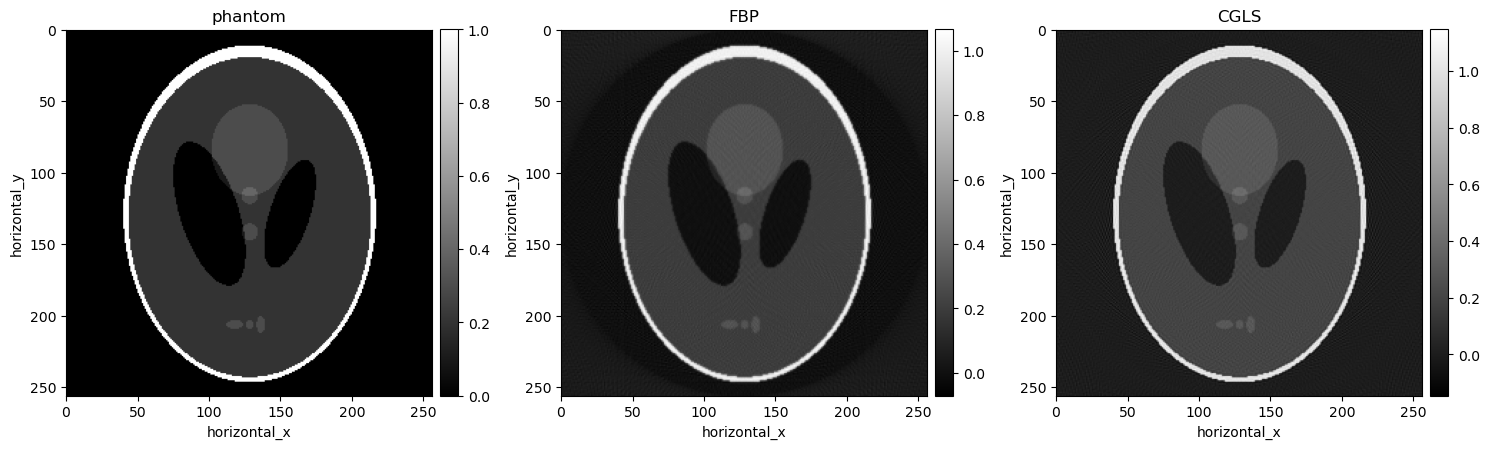

In [20]:
# get and visualise the results
recon_cgls = cgls.solution

show2D([phantom, recon_fbp, recon_cgls], ['phantom', 'FBP', 'CGLS'], \
       cmap=cmap, num_cols=3, size=(15,10), origin='upper-left')

## Adding some complexity

In the example above we worked with an ideal (i.e. noise- or artifacts-free) sinogram acquired over the sufficient number of rotation positions which is not always the case with datasets obtained in real experiments. Let us take a look at how both FBP and CGLS algorithms will perform on noisy and/or insufficient data.

Poisson noise will be applied to this noise-free sinogram. The severity of the noise can be adjusted by changing the `background_counts` variable.

In [21]:
# Incident intensity: lower counts will increase the noise
background_counts = 20000 

# Convert the simulated absorption sinogram to transmission values using Lambert-Beer. 
# Use as mean for Poisson data generation.
# Convert back to absorption sinogram.
counts = background_counts * np.exp(-sino.as_array())
tmp = np.exp(-sino.as_array())
noisy_counts = np.random.poisson(counts)
nonzero = noisy_counts > 0
sino_out = np.zeros_like(sino.as_array())
sino_out[nonzero] = -np.log(noisy_counts[nonzero] / background_counts)

# allocate sino_noisy and fill with noisy data
sino_noisy = ag.allocate()
sino_noisy.fill(sino_out)

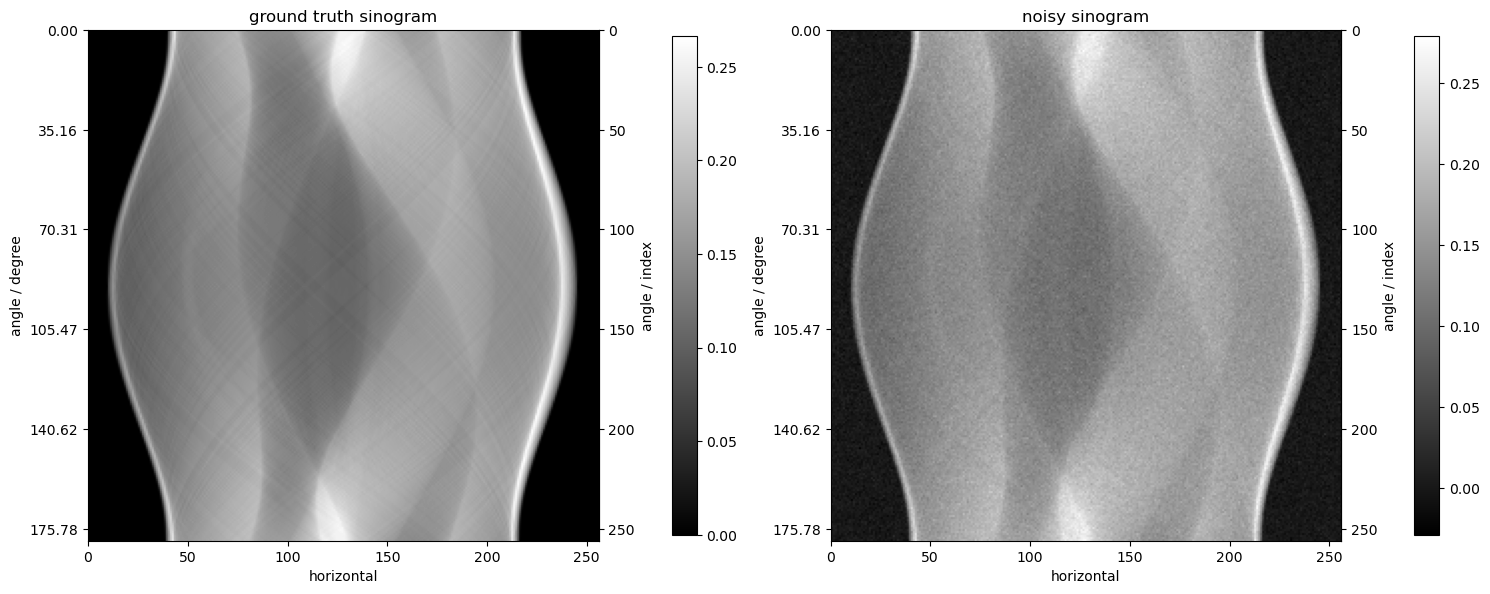

In [22]:
# visualise results
show2D([sino, sino_noisy], ['ground truth sinogram', 'noisy sinogram'], \
       cmap=cmap, num_cols=2, size=(15,10), origin='upper-left')

In [23]:
# reconstruct noisy data
# configure FBP
fbp = FBP(ig, ag, device)
# run on the AcquisitionData
recon_fbp_noisy = fbp(sino_noisy)

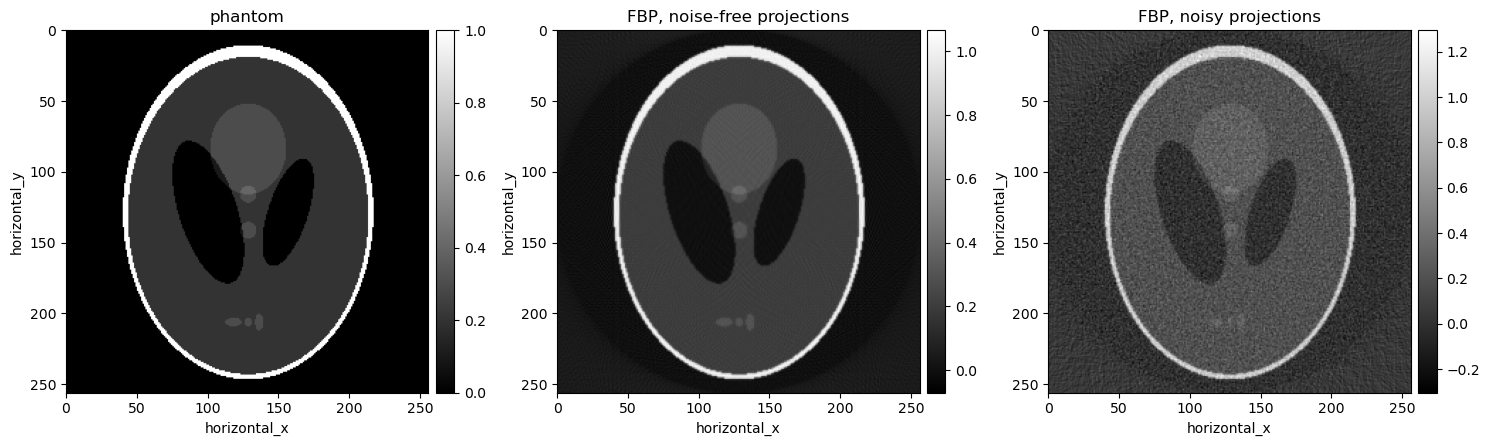

In [24]:
# visualise results
show2D([phantom, recon_fbp, recon_fbp_noisy], ['phantom', 'FBP, noise-free projections', 'FBP, noisy projections'], \
       cmap=cmap, num_cols=3, size=(15,10), origin='upper-left')

The reconstruction above doesn't look particularly good. Let us try to reconstruct the same noisy dataset using the CGLS method. In CGLS without explicit regularisation, the number of iterations plays the role of a regularisation parameter. However, it is often unclear how many iterations is required to get 'good' reconstruction. To control how the reconstruction result changes with every iteration, we will visualise intermediate reconstruction results.

In [25]:
# initial estimate - zero array in this case 
initial = ig.allocate(0)

max_iter = 20

# setup CGLS
cgls = CGLS(initial=initial, 
            operator=A, 
            data=sino_noisy,
            max_iteration = max_iter )

previous = initial

Let's run the algorithm, and check its progress to the solution after every iteration.
We'll plot the current solution, the difference with the ground truth, and the difference with the previous iteration.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         20         0.000          1.30175e+03
        1         20         0.031          1.24456e+02
-------------------------------------------------------
        1         20         0.031          1.24456e+02
Stop criterion has been reached.



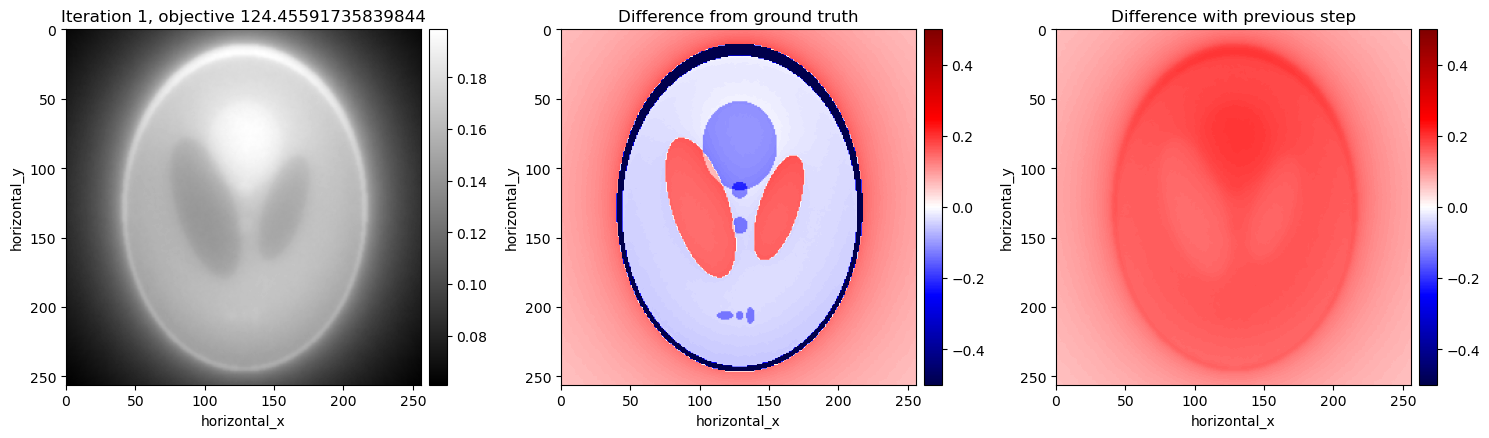

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        1         20         0.031          1.24456e+02
        2         20         0.031          4.64386e+01
-------------------------------------------------------
        2         20         0.031          4.64386e+01
Stop criterion has been reached.



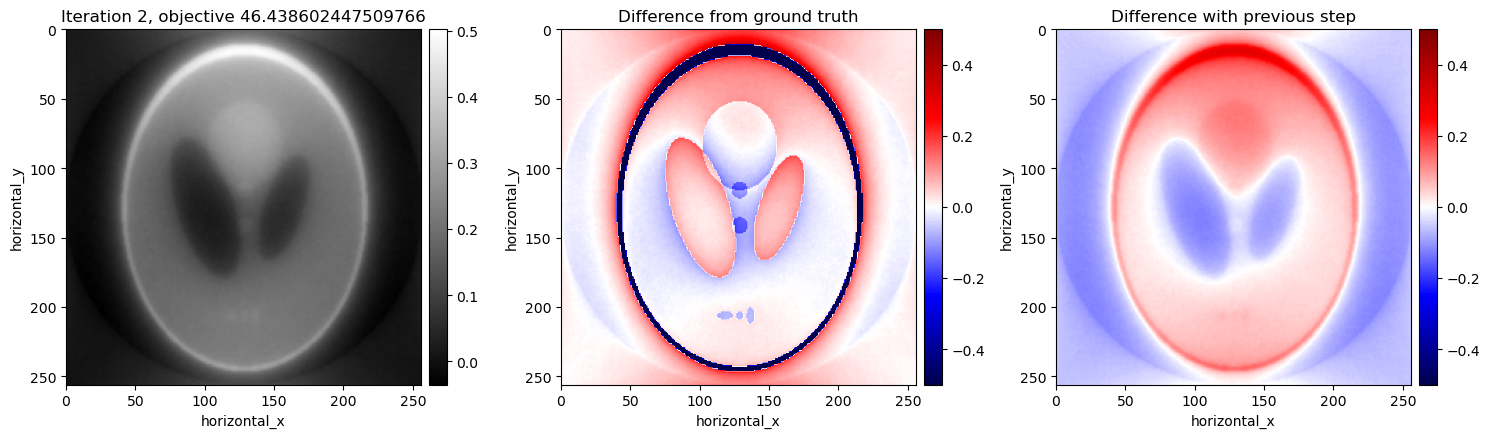

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        2         20         0.031          4.64386e+01
        3         20         0.031          2.55610e+01
-------------------------------------------------------
        3         20         0.031          2.55610e+01
Stop criterion has been reached.



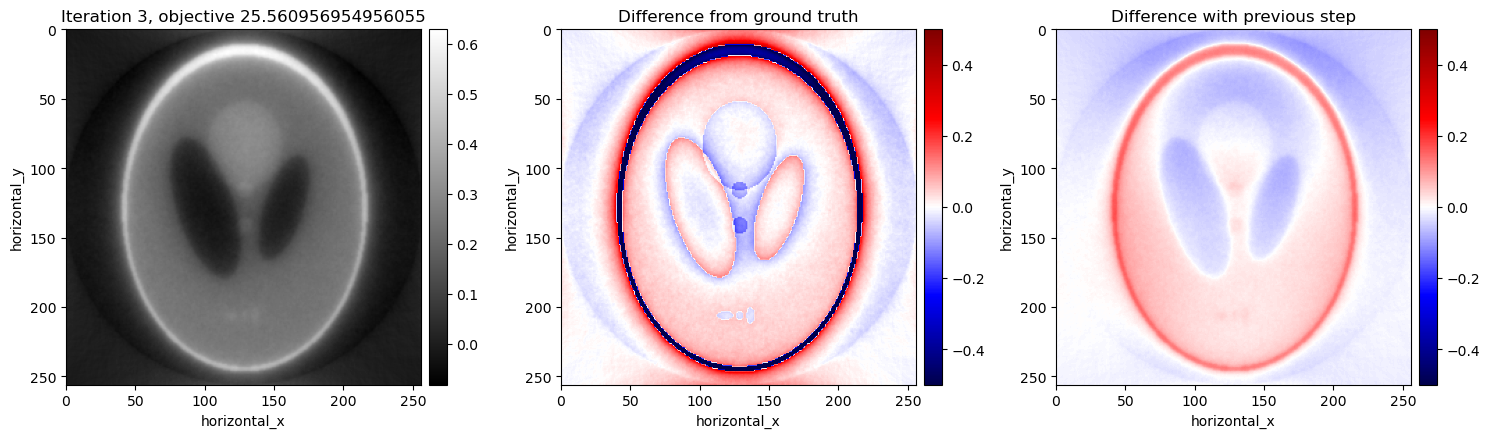

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        3         20         0.031          2.55610e+01
        4         20         0.031          1.56182e+01
-------------------------------------------------------
        4         20         0.031          1.56182e+01
Stop criterion has been reached.



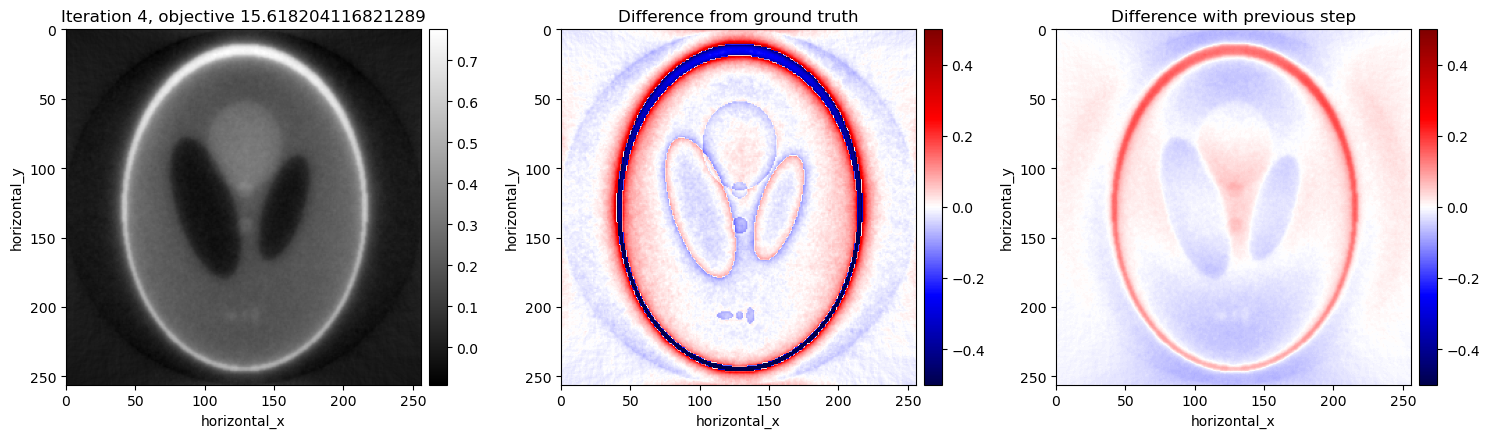

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        4         20         0.031          1.56182e+01
        5         20         0.030          8.76354e+00
-------------------------------------------------------
        5         20         0.030          8.76354e+00
Stop criterion has been reached.



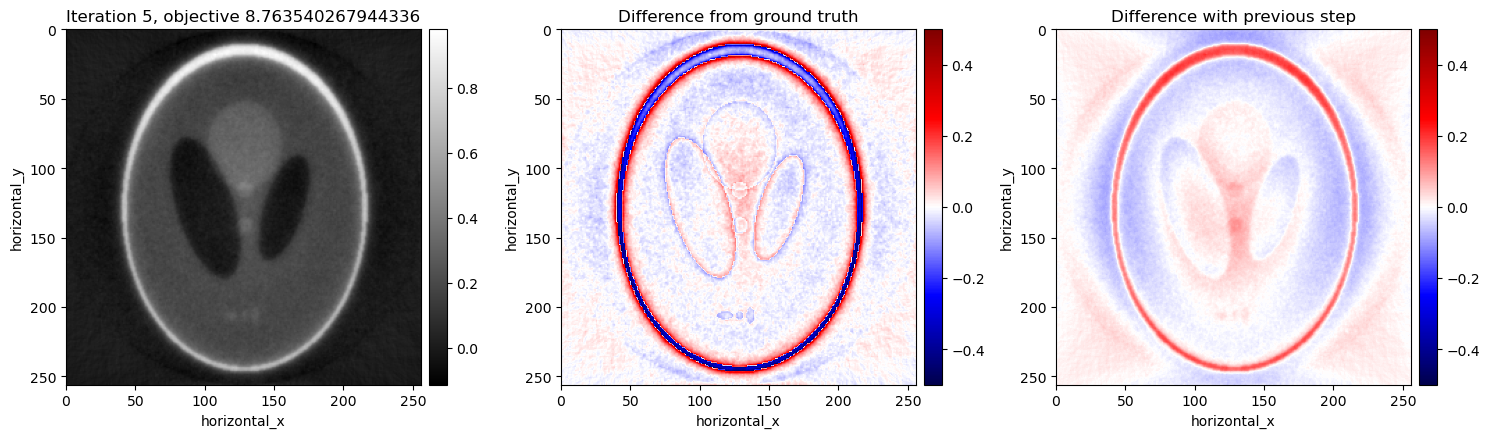

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        5         20         0.030          8.76354e+00
        6         20         0.031          5.70782e+00
-------------------------------------------------------
        6         20         0.031          5.70782e+00
Stop criterion has been reached.



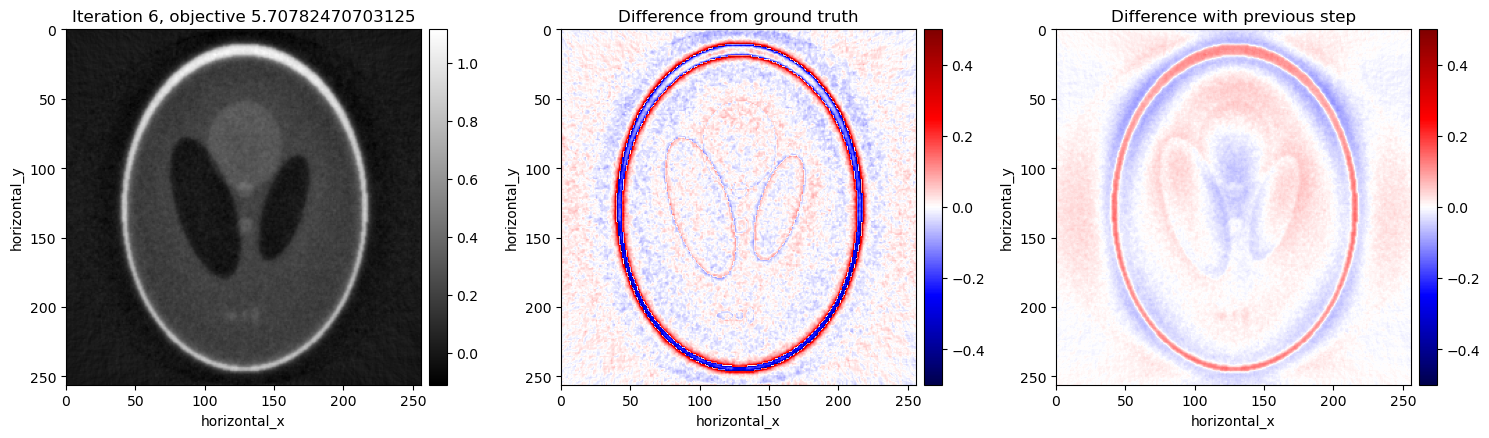

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        6         20         0.031          5.70782e+00
        7         20         0.031          5.31068e+00
-------------------------------------------------------
        7         20         0.031          5.31068e+00
Stop criterion has been reached.



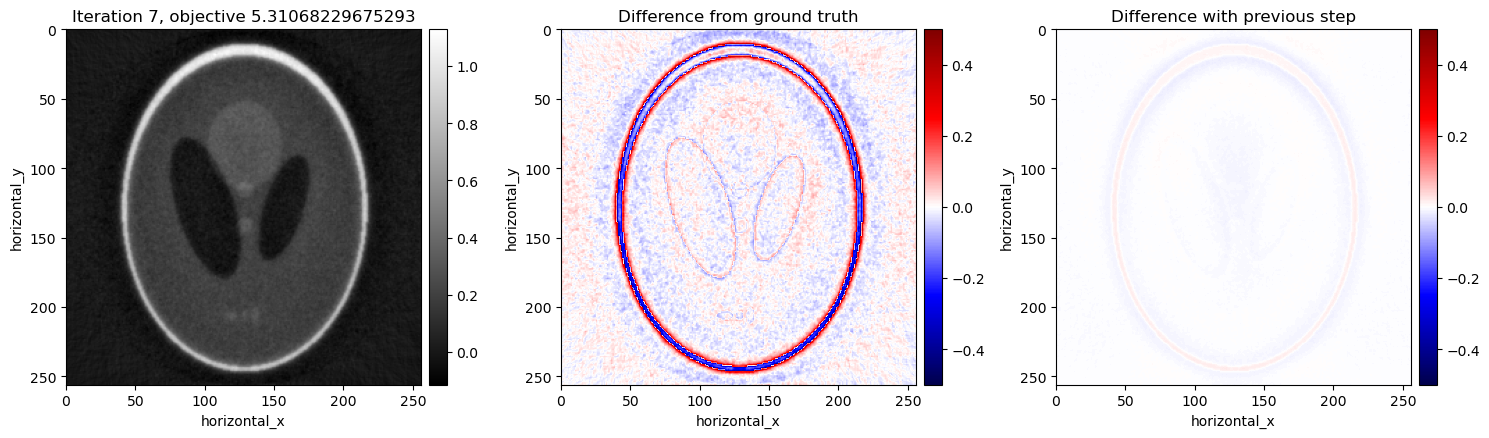

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        7         20         0.031          5.31068e+00
        8         20         0.032          4.06641e+00
-------------------------------------------------------
        8         20         0.032          4.06641e+00
Stop criterion has been reached.



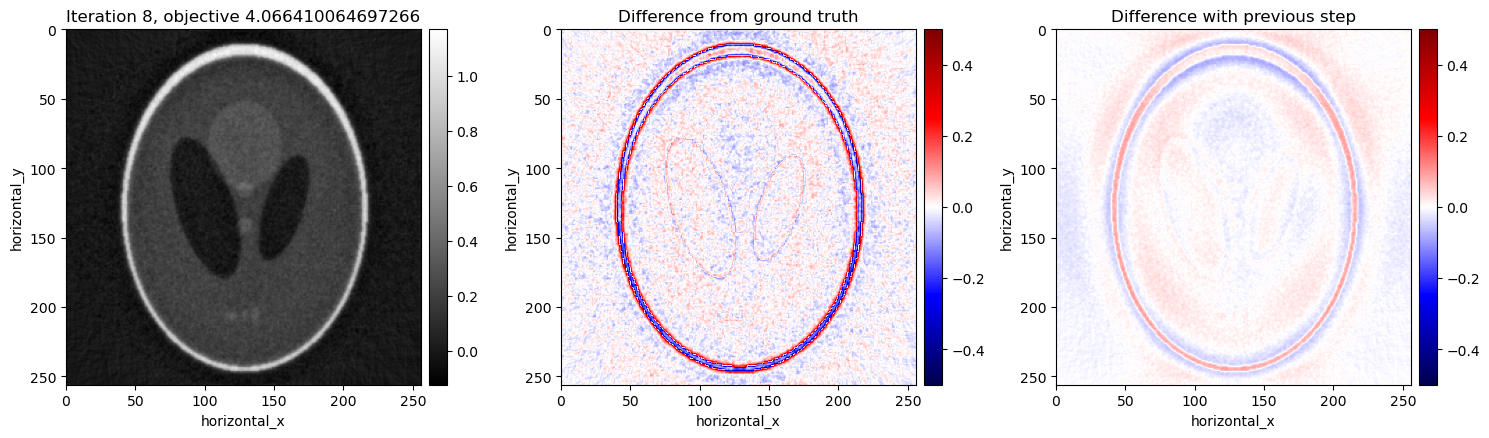

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        8         20         0.032          4.06641e+00
        9         20         0.032          3.29977e+00
-------------------------------------------------------
        9         20         0.032          3.29977e+00
Stop criterion has been reached.



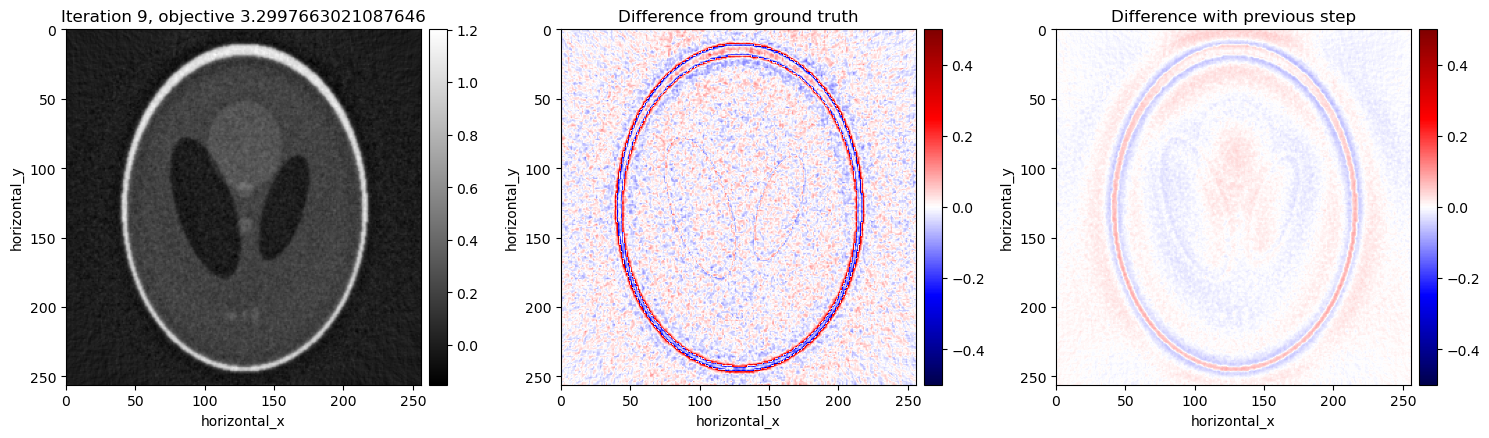

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        9         20         0.032          3.29977e+00
       10         20         0.032          2.93117e+00
-------------------------------------------------------
       10         20         0.032          2.93117e+00
Stop criterion has been reached.



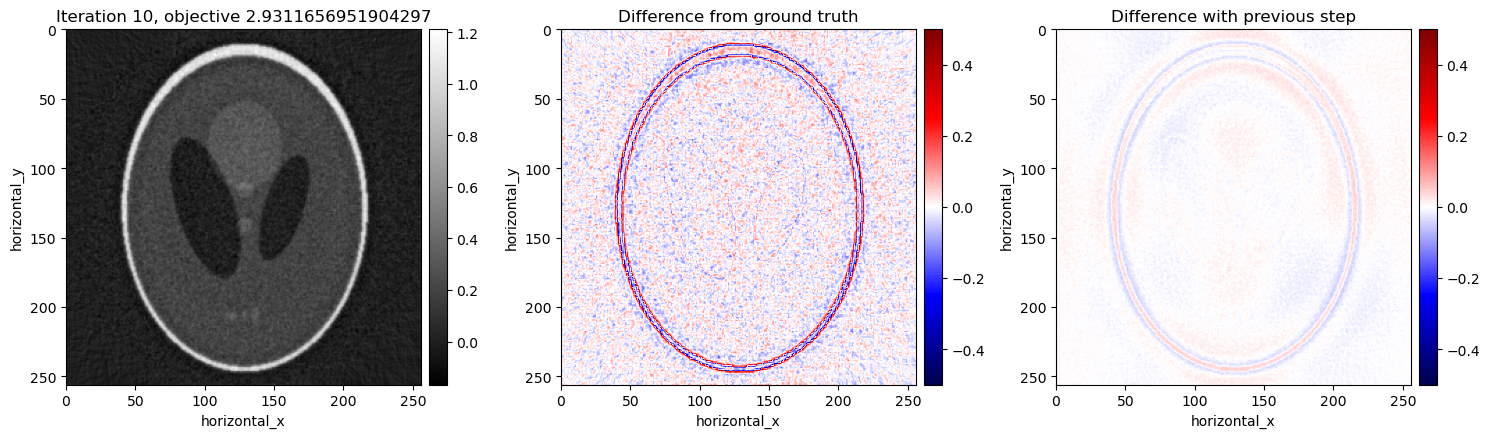

In [26]:
for i in range(10):
    previous = cgls.solution.copy()

    cgls.run(1, verbose=True)

    # get and visualise the results
    diff = cgls.solution - phantom
    # set the colormaps of the plot: gray for the solution, seismic a symmetric colormap for the difference
    cmaps = [cmap, 'seismic', 'seismic']
    # create a symmetric range for the difference centred on 0
    ranges = [None, (-0.5, 0.5), (-0.5, 0.5)]

    #use show2D to display the 3 plots with there own colour map and ranges
    show2D([cgls.solution, diff, cgls.solution - previous],
            ["Iteration {}, objective {}".format(cgls.iteration, cgls.loss[-1]), 
                "Difference from ground truth",
                "Difference with previous step"
            ],
            fix_range=ranges, cmap=cmaps, origin='upper-left', num_cols=3 )

You can see that after iteration 6, the reconstruction gets increasingly more noisy even though the objective value keeps decreasing. After iteration 10, you cannot see significant changes in the reconstruction result.

Let us re-run CGLS, this time we will stop at iteration 6 and compare this solution with other algorithms.

In [27]:
# re-run CGLS reconstruction with 6 iterations
# setup CGLS
cgls = CGLS(initial=initial, 
            operator=A, 
            data=sino_noisy)
cgls.max_iteration = 100

cgls.run(6, verbose=True)
    
# get the results
recon_cgls_noisy = cgls.solution

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          1.30175e+03
        1        100         0.027          1.24456e+02
        2        100         0.026          4.64386e+01
        3        100         0.027          2.55610e+01
        4        100         0.026          1.56182e+01
        5        100         0.025          8.76354e+00
        6        100         0.027          5.70782e+00
-------------------------------------------------------
        6        100         0.027          5.70782e+00
Stop criterion has been reached.



### Constrained reconstruction

Perhaps the most intuitive constraint one can enforce on reconstructed data is the non-negativity constraint. The image data we are reconstructing is the linear attenuation coefficient of the material, so intuitively this cannot have a negative value. Here we employ the SIRT algorithm,  an  algebraic  iterative  method  for  a particular weighted least-squares problem which in addition accepts certain convex constraints such as a non-negativity constraint. As with CGLS, it exhibits semi-convergence, however tends to require more iterations. We enforce box constraints (lower and upper bounds) with the `IndicatorBox` function.

In [28]:
x0 = ig.allocate()
constraint = IndicatorBox(lower=0)

sirt = SIRT(initial=x0, operator=A, data=sino_noisy, constraint=constraint, max_iteration=100)
sirt.update_objective_interval = 10
sirt.run(100)

recon_sirt_noisy = sirt.solution

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          1.30175e+03
       10        100         0.023          4.99169e+01
       20        100         0.023          2.41727e+01
       30        100         0.023          1.56516e+01
       40        100         0.024          1.16362e+01
       50        100         0.024          9.40574e+00
       60        100         0.024          8.03878e+00
       70        100         0.024          7.14105e+00
       80        100         0.024          6.52107e+00
       90        100         0.024          6.07480e+00
      100        100         0.024          5.74136e+00
-------------------------------------------------------
      100        100         0.024          5.74136e+00
Stop criterion has been reached.



Let us compare the reconstruction of the noisy data using FBP, CGLS and SIRT. What do you notice? What conclusions can you draw from the comparison?

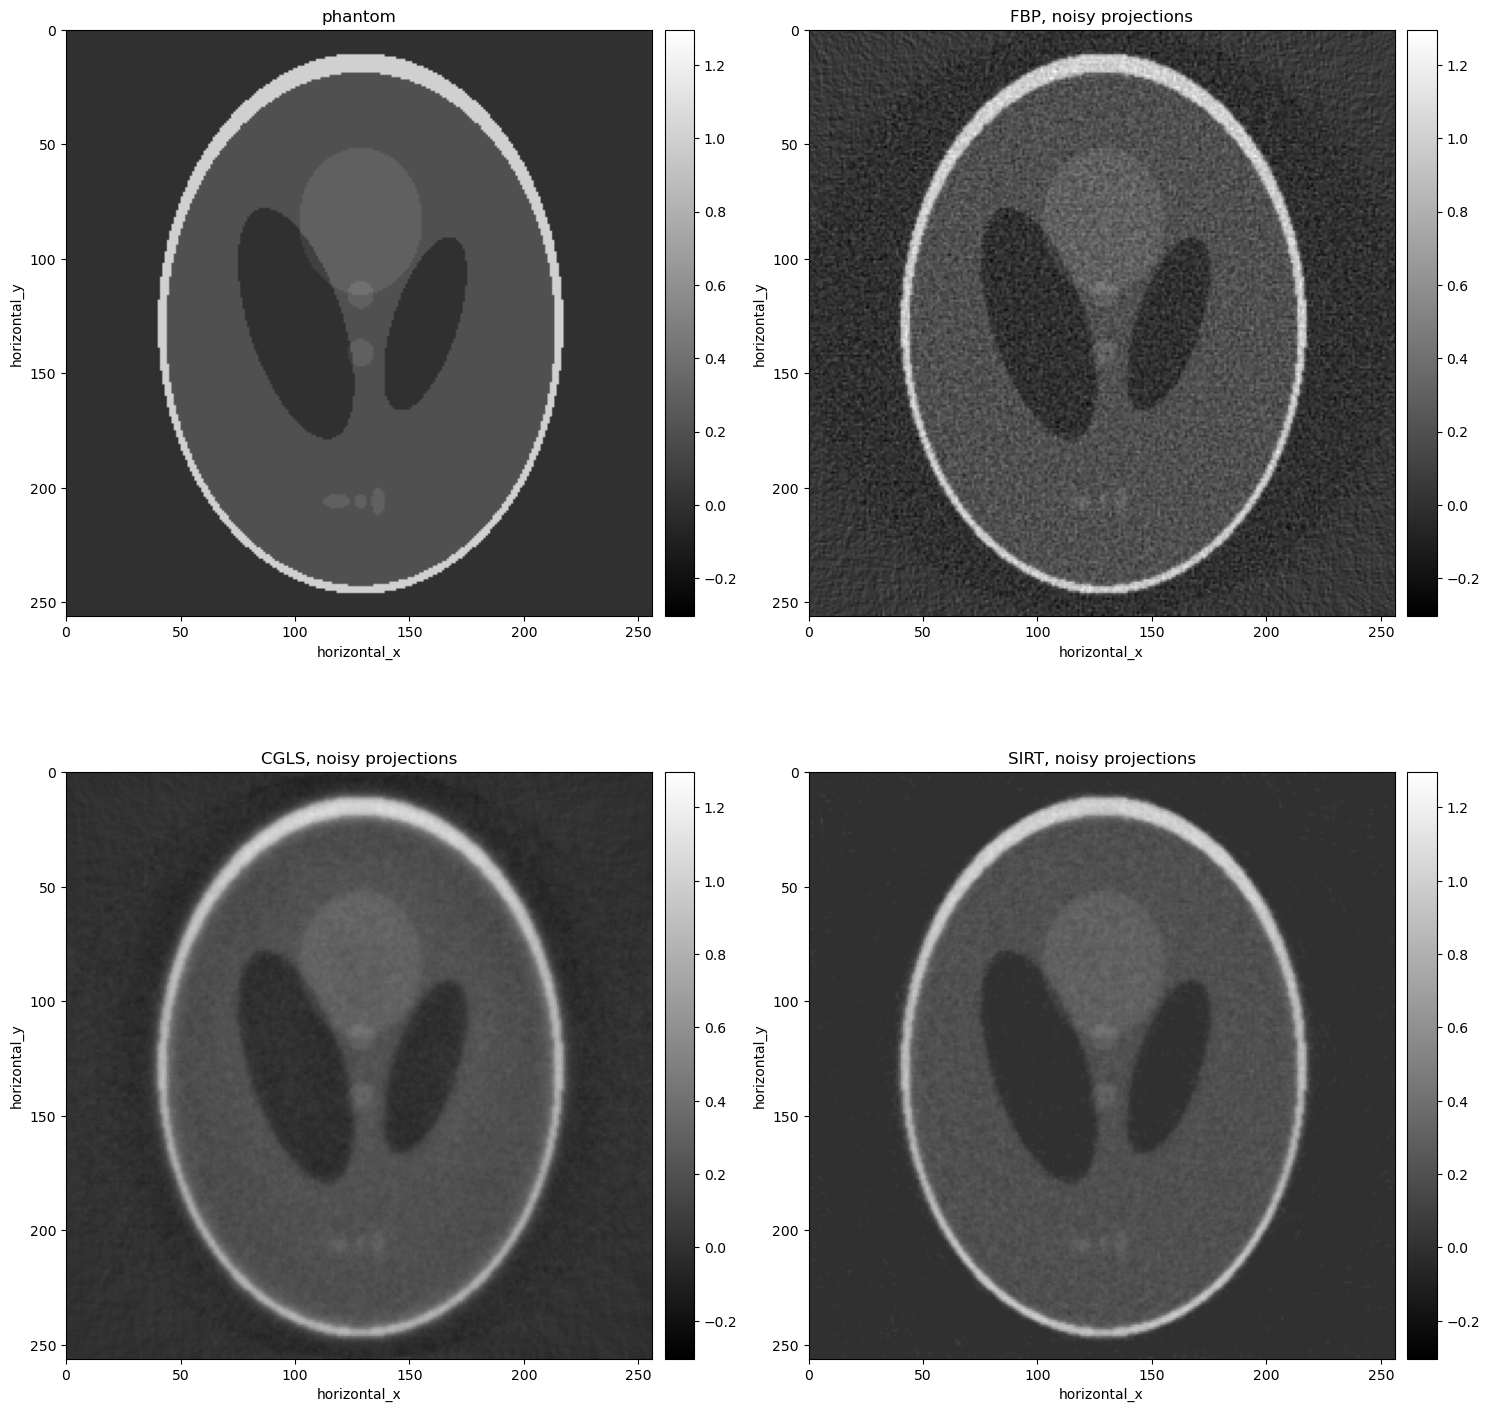

In [29]:
show2D([phantom, recon_fbp_noisy, recon_cgls_noisy, recon_sirt_noisy], \
       ['phantom', 'FBP, noisy projections', 'CGLS, noisy projections', 'SIRT, noisy projections'], \
       cmap=cmap, num_cols=2, size=(15,15), origin='upper-left', fix_range=True)

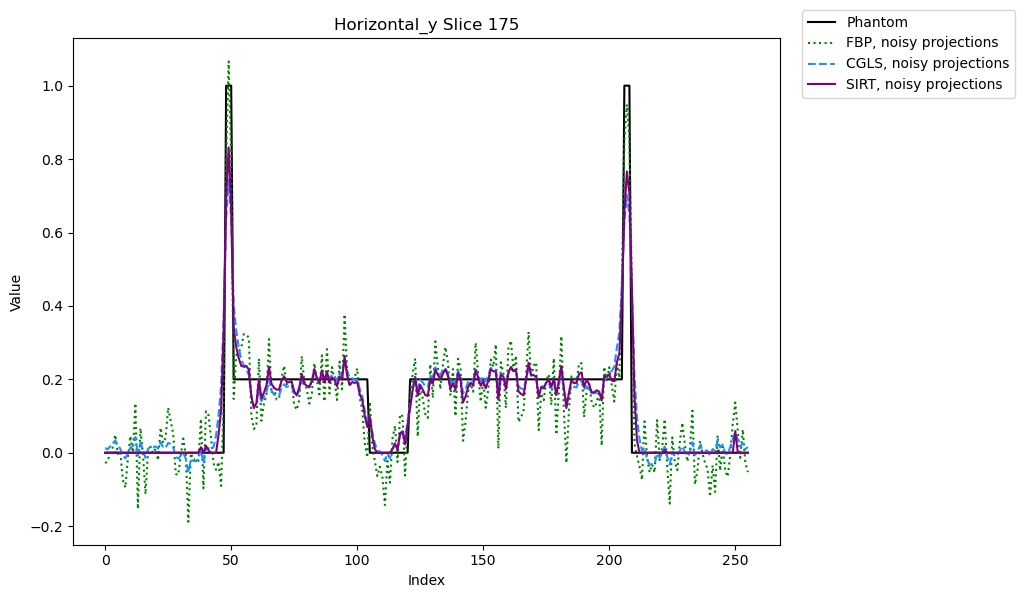

In [30]:
show1D([phantom, recon_fbp_noisy, recon_cgls_noisy, recon_sirt_noisy],
       slice_list=[("horizontal_y",175)],
       label=["Phantom","FBP, noisy projections","CGLS, noisy projections", "SIRT, noisy projections"],
       line_colours=['black','green','dodgerblue','purple'],
       line_styles=['solid','dotted','dashed','solid'],
       title=("Horizontal_y Slice {}".format(175)))

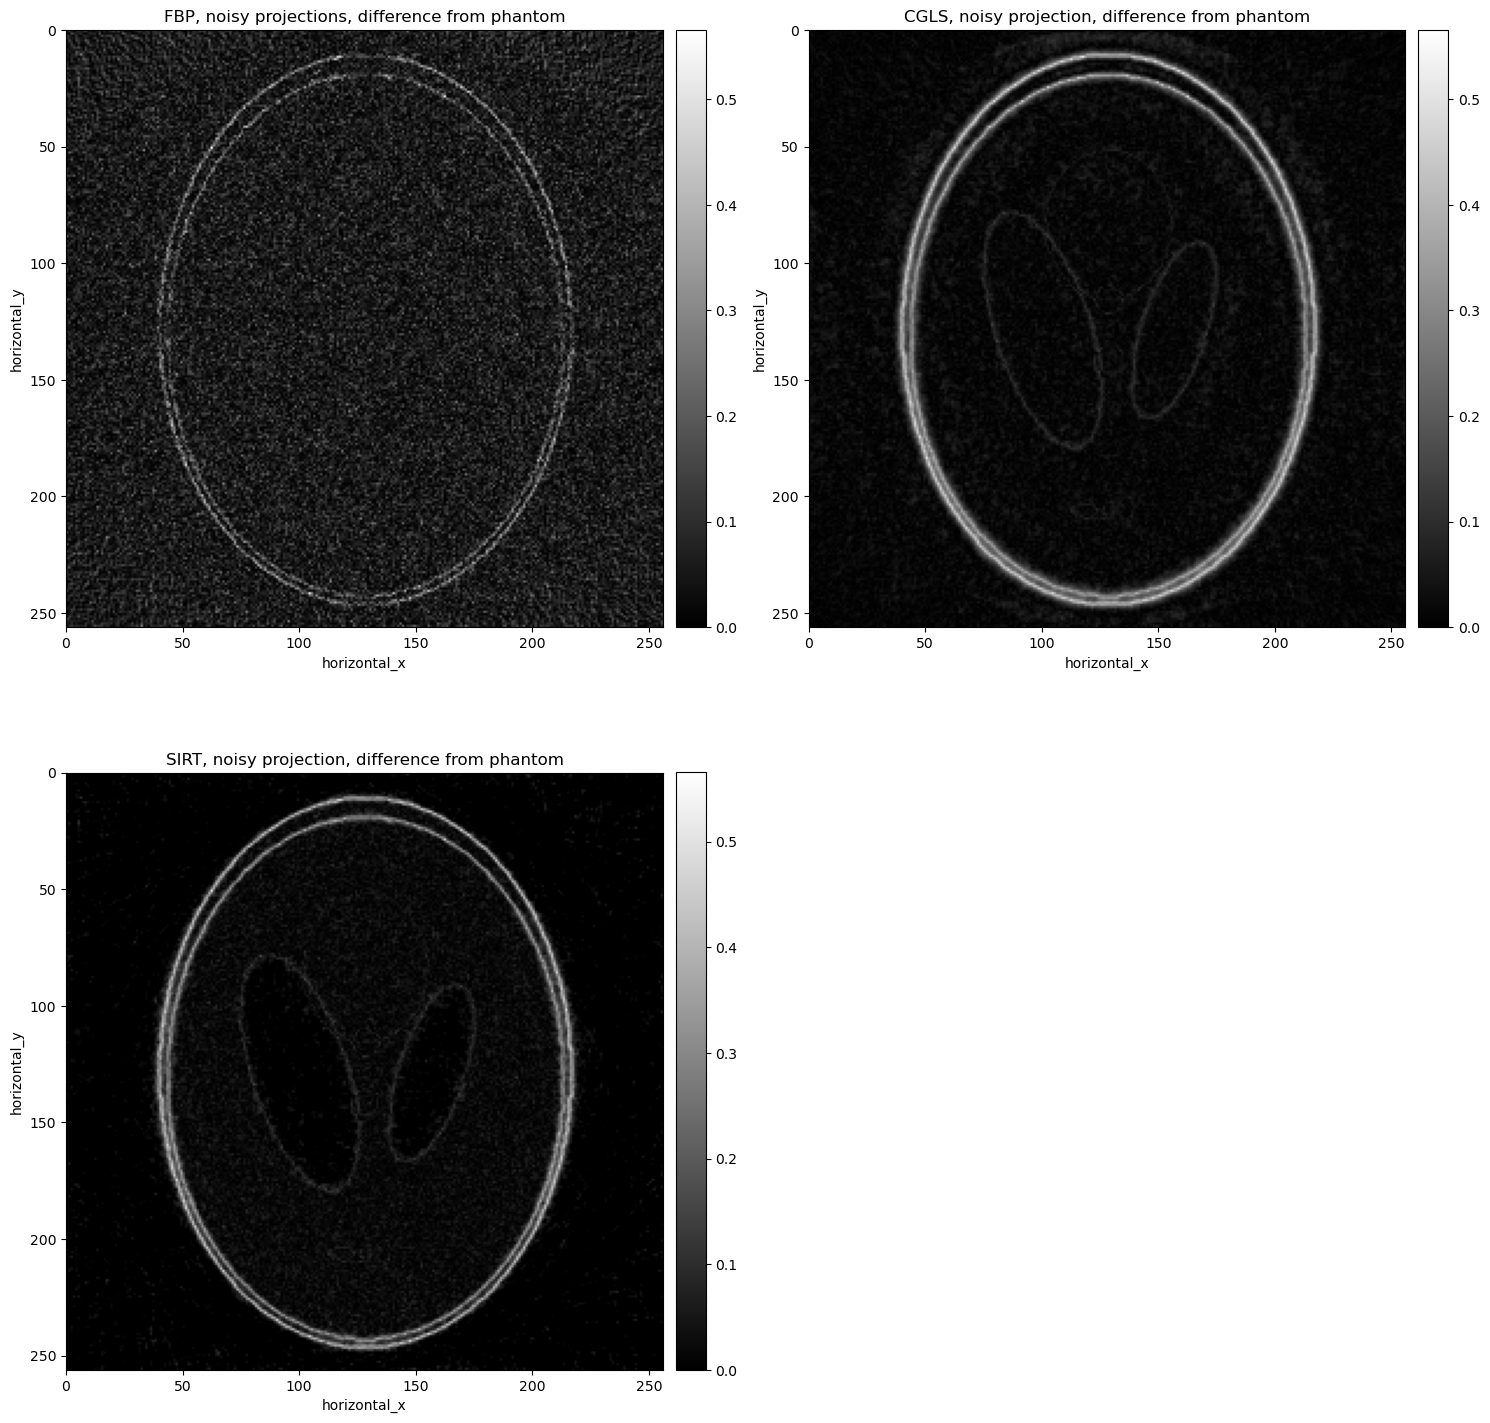

In [31]:
show2D([(recon_fbp_noisy-phantom).abs(), (recon_cgls_noisy-phantom).abs(), (recon_sirt_noisy-phantom).abs()], \
       ['FBP, noisy projections, difference from phantom', 'CGLS, noisy projection, difference from phantom', 'SIRT, noisy projection, difference from phantom'], \
       cmap=cmap, num_cols=2, size=(15,15), origin='upper-left', fix_range=True)